This notebook is for testing portfolio creation methods   

Check does pyportfolio opt use yearly returns   
drop any which have negative returns   

we have a problem which creeps in as we increase the # of input columns investigationg if this is due to anomalies in some columns of is just a result of taking in so many columns.
- *The covariance matrix is non positive semidefinite. Amending eigenvalues. Could not fix matrix. Please try a different risk model.*
- Issue is around rows to column ratio see issue on [PyPortfolioOpt #263](https://github.com/robertmartin8/PyPortfolioOpt/issues/263)


Currently working on a function that calculates an optimal sharpe portfolio & tests its performance on the following year(always test on a 1 year period but can use multiple years of data for input)   

**Inputs:**
- closing price Database *DataFrame*
- startdate *yyyy-mm-dd*
- enddate *yyyy-mm-dd*  

**Outputs** (Array)
- startdate *yyyy-mm-dd*
- enddate *yyyy-mm-dd*
- years of input data (ie Years(enddate-startdate)) *float*
- optimal portfolio Expected performance *float*
- optimal portfolio Actual performance *float*
- performance of the market (ie total change of the input markets value over the test year) *float*


Do some expected returns histograms to visualise


In [1]:
#Import the libraries
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import math
from datetime import timedelta 
import operator
from functools import reduce
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import cvxpy as cp
from joblib import Parallel, delayed
import seaborn as sns

import DatabaseMainFnc as dmf
pd.set_option('display.max_columns', 38)
plt.rcParams['figure.figsize'] = [10, 5]


In [2]:
def net_gains(principal,expected_returns,years,people=1):
    """Calculates the net gain after Irish Capital Gains Tax of a given principal for a given expected_returns over a given period of years"""
    cgt_tax_exemption=1270*people
    cgt_tax_rate=0.33
    total_p=principal
    year=0
    while year < years:
        year+=1
        gross_returns=total_p*expected_returns
        if gross_returns >cgt_tax_exemption:
            taxable_returns=gross_returns-cgt_tax_exemption
            net_returns=cgt_tax_exemption+(taxable_returns*(1-cgt_tax_rate))
        else:
            net_returns=gross_returns
        total_p= total_p + net_returns
    return total_p

In [3]:
net_gains(3000,0.70,5,people=2)

30285.1081406409

In [4]:
%%time
df_Nasdaq=dmf.connectAndLoadDb('NASDAQ')
df_Nasdaq=df_Nasdaq.set_index(pd.DatetimeIndex(df_Nasdaq['Date'].values))
df_Nasdaq.drop(columns=['Date'],axis=1, inplace=True)

df_NYSE=dmf.connectAndLoadDb('NYSE')
df_NYSE=df_NYSE.set_index(pd.DatetimeIndex(df_NYSE['Date'].values))
df_NYSE.drop(columns=['Date'],axis=1, inplace=True)
df_Nasdaq.tail(10)

Connecting database:NASDAQ
Database connected!
Connecting database:NYSE
Database connected!
Wall time: 7.27 s


,AACG,AACQ,AACQU,AAL,AAME,AAOI,AAON,AAPL,AAWW,AAXJ,ABCB,ABCL,ABCM,ABEO,ABGI,ABIO,ABMD,ABNB,ABST,...,ZIONO,ZIONP,ZIOP,ZIXI,ZKIN,ZLAB,ZM,ZNGA,ZNTE,ZNTEU,ZNTEW,ZNTL,ZS,ZSAN,ZUMZ,ZVO,ZWRKU,ZYNE,ZYXI
2021-02-24,5.06,11.80,12.87,21.820000,4.53,11.610,77.879997,125.349998,59.090000,97.660004,50.240002,40.099998,22.459999,2.20,10.36,4.71,323.779999,200.199997,15.14,...,26.248926,25.000999,4.90,9.59,8.55,156.899994,385.230011,11.29,11.33,12.61,2.835,40.259998,207.809998,1.40,47.990002,6.21,10.590,5.010,18.42
2021-02-25,5.06,11.23,12.08,20.860001,4.63,11.170,76.629997,120.989998,56.070000,95.980003,48.119999,39.060001,22.850000,2.49,10.25,4.39,320.470001,182.059998,14.75,...,25.786001,25.058500,4.65,9.26,7.40,147.389999,364.730011,11.04,10.94,12.14,2.750,40.410000,195.789993,1.30,46.520000,5.52,10.460,4.460,17.42
2021-02-26,5.05,10.88,11.92,20.940001,4.47,9.325,77.099998,121.260002,55.130001,94.650002,47.639999,37.709999,23.830000,2.42,10.26,4.21,324.549988,206.350006,15.19,...,26.120001,24.559999,5.33,7.38,6.01,147.520004,373.609985,11.15,10.89,11.96,2.635,42.040001,205.029999,1.28,45.080002,5.13,10.410,4.495,14.52
2021-03-01,5.15,11.23,12.01,21.180000,4.76,9.020,77.379997,127.790001,55.320000,97.339996,49.020000,39.689999,22.590000,2.34,10.25,4.37,324.260010,196.419998,15.60,...,26.080000,24.832500,5.26,7.42,7.44,162.020004,409.660004,11.56,10.96,12.14,2.710,41.730000,210.160004,1.33,47.060001,5.19,10.330,4.660,14.69
2021-03-02,5.07,10.73,11.51,21.440001,4.70,8.625,74.919998,125.120003,56.570000,95.930000,48.970001,38.000000,22.920000,2.36,10.14,4.52,325.309998,189.899994,15.66,...,26.120001,24.910000,5.07,7.35,6.40,148.009995,372.790009,11.39,10.57,11.55,2.400,43.500000,202.610001,1.25,46.540001,5.29,10.150,4.680,14.25
2021-03-03,4.63,10.38,11.03,22.170000,4.43,8.360,74.089996,122.059998,57.189999,95.620003,50.160000,35.669998,22.209999,2.19,10.09,4.27,307.600006,180.399994,14.56,...,26.080000,24.934999,4.68,6.97,6.29,140.669998,341.570007,11.09,10.35,11.06,1.830,43.630001,187.830002,1.22,46.330002,5.09,10.025,4.510,14.25
2021-03-04,4.26,10.29,10.79,21.240000,3.65,7.990,72.070000,120.129997,55.139999,93.389999,49.860001,30.049999,21.129999,2.08,9.99,3.98,295.630005,180.229996,14.13,...,26.420000,25.110001,4.31,7.13,5.20,133.070007,343.089996,10.48,10.20,10.95,1.510,43.549999,180.899994,1.07,45.389999,4.61,10.000,4.090,14.54
2021-03-05,4.08,10.66,11.34,20.450001,3.67,8.045,72.800003,121.419998,57.650002,94.459999,50.349998,28.610001,21.110001,2.01,9.97,4.12,301.220001,179.809998,13.85,...,26.530001,24.760000,4.29,7.15,5.18,137.250000,337.429993,10.31,10.36,11.19,1.850,42.330002,175.369995,1.07,46.029999,4.72,10.200,4.150,14.75
2021-03-08,4.01,10.68,11.24,21.469999,3.55,7.760,73.150002,116.360001,57.360001,91.610001,51.650002,26.760000,19.700001,2.10,10.07,3.98,285.920013,180.809998,13.62,...,26.490000,24.900000,4.07,7.01,5.05,127.559998,310.929993,9.85,10.19,10.98,1.660,39.369999,167.839996,1.19,48.660000,4.91,10.155,4.140,16.24
2021-03-09,4.37,10.67,11.33,21.600000,3.80,8.450,73.750000,121.089996,58.599998,93.779999,51.619999,30.639999,20.809999,2.18,9.99,4.06,296.799988,183.110001,14.92,...,26.830000,24.969999,4.61,7.66,6.15,135.139999,342.109985,10.28,10.23,11.06,1.650,42.889999,181.429993,1.18,47.700001,5.18,10.350,4.540,17.57


In [10]:
database=df_Nasdaq
startdate="2018-01-01"
enddate="2020-01-01"

# Subset for date range
df_input=database[startdate:enddate]
print ("Initial number of stocks: "+str(len(df_input.columns)))

#Check for stocks which are too expensive for us to buy & drop those
p_max=500
p_now=database.iloc[-1,:]
df_unaffordable=p_now[p_now>p_max] #we can set max price here maybe as an optional
l_unaffordable=df_unaffordable.index.tolist()
df_input.drop(columns=l_unaffordable, inplace=True)
print ("-----------------------------------------------------")
print ("Our max price is : €"+str(p_max))
print ("Number of stocks due being unnaffordble: "+str(len(l_unaffordable)))
print ("Number of stocks remaining: "+str(len(df_input.columns)))


# drop any columns with more than half or more Nas as the models dont like these
half_length=int(len(df_input)*0.50)
l_drop=df_input.columns[df_input.iloc[:half_length,:].isna().all()].tolist()
df_input.drop(columns=l_drop, inplace=True)
print ("-----------------------------------------------------")
print ("Number of stocks due to NAs: "+str(len(l_drop)))
print ("Number of stocks remaining: "+str(len(df_input.columns)))


#see which stocks have negative returns or low returns in the period & drop those
df_pct=(df_input.iloc[-1,:] / df_input.iloc[0,:])-1
df_pct=df_pct[df_pct<=0.01] #we can set minimum returns here maybe as an optional
l_pct=df_pct.index.tolist()
df_input.drop(columns=l_pct, inplace=True)
print ("-----------------------------------------------------")
print ("Number of stocks due to Negative returns: "+str(len(l_pct)))
print ("Number of stocks remaining: "+str(len(df_input.columns)))
print ("Number of days data: "+str(len(df_input)))
print ("If Number of days data < Number of stocks remaining, we need to further reduce the stocks by breaking it out in smaller groups or use a longer time window")

#We will only keep the 500  best performing assets can make tis an optional input
df=df_input
mu = expected_returns.mean_historical_return(df)
top_stocks = mu.sort_values(ascending=False).index[:250]
df = df[top_stocks]

#Calculate expected annulised returns & annual sample covariance matrix of the daily asset
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)


Initial number of stocks: 4019
-----------------------------------------------------
Our max price is : €500
Number of stocks due being unnaffordble: 24
Number of stocks remaining: 3995
-----------------------------------------------------
Number of stocks due to NAs: 1150
Number of stocks remaining: 2845
-----------------------------------------------------
Number of stocks due to Negative returns: 1250
Number of stocks remaining: 1595
Number of days data: 505
If Number of days data < Number of stocks remaining, we need to further reduce the stocks by breaking it out in smaller groups or use a longer time window


In [14]:
%%time
# Optomise for maximal Sharpe ratio
ef= EfficientFrontier(mu, S) #Create the Efficient Frontier Object
weights = ef.max_sharpe()
cl_weights= ef.clean_weights()
#print(cl_weights)
#print('')
print("Our Benchmark portfolio the S&P 500 has: Volatility  18.1% & Annual Return: 10.6%")
print("-------------------------------------------------------------")
ef.portfolio_performance(verbose=True)

Our Benchmark portfolio the S&P 500 has: Volatility  18.1% & Annual Return: 10.6%
-------------------------------------------------------------
Expected annual return: 140.4%
Annual volatility: 14.8%
Sharpe Ratio: 9.33
Wall time: 233 ms


(1.404367445745886, 0.14844541443467615, 9.325767663608639)

In [7]:
# Get the discrete allocation of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

portfolio_val = 3000
latest_prices=get_latest_prices(df)
weights=cl_weights
da=DiscreteAllocation(weights,latest_prices,total_portfolio_value=portfolio_val).greedy_portfolio()
allocation, leftover = da.lp_portfolio()

print('Discrete allocation  :', allocation)
print('Funds Remaining:', leftover)

AttributeError: 'tuple' object has no attribute 'lp_portfolio'

Expected annual return: 530.4%
Annual volatility: 16.9%
Sharpe Ratio: 31.27


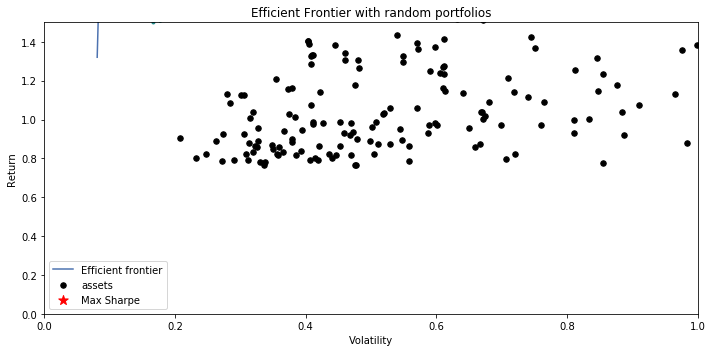

In [177]:
#Graphing 

ef = EfficientFrontier(mu, S)


fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find the tangency portfolio
ef.max_sharpe()
ef.clean_weights()
ret_tangent, std_tangent, _ = ef.portfolio_performance(verbose=True)
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets/ stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.5])
plt.tight_layout()
plt.show()
